In [1]:
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd
import os
import numpy as np
from tqdm import trange
import librosa
from utils import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
metadata = torchaudio.info('vowelAudio/a/aData_19_46_48.wav')
print_metadata(metadata)

 - sample_rate: 44100
 - num_channels: 2
 - num_frames: 88064
 - bits_per_sample: 16
 - encoding: PCM_S



In [7]:
os.listdir('vowelAudio/u')

['uData_19_45_54.wav',
 'uData_19_45_40.wav',
 'uData_19_45_44.wav',
 'uData_19_45_51.wav',
 'uData_19_45_37.wav',
 'uData_19_45_21.wav',
 'uData_19_45_25.wav',
 'uData_19_45_33.wav',
 'uData_19_45_29.wav',
 'uData_19_45_12.wav',
 'uData_19_45_07.wav',
 'uData_19_45_48.wav']

In [24]:
d = {'fname': [], 'label': []}
for dir in os.listdir('vowelAudio'):
    for file in os.listdir('vowelAudio/'+dir):
        d['fname'].append(file)
        d['label'].append(dir)
df = pd.DataFrame.from_dict(d)
df.head()

,fname,label
0,uData_19_45_54.wav,u
1,uData_19_45_40.wav,u
2,uData_19_45_44.wav,u
3,uData_19_45_51.wav,u
4,uData_19_45_37.wav,u


a
torch.Size([1, 128, 221])
e
torch.Size([1, 128, 221])
i
torch.Size([1, 128, 221])
o
torch.Size([1, 128, 221])
u
torch.Size([1, 128, 221])


<Figure size 432x288 with 0 Axes>

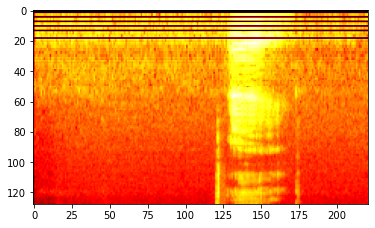

<Figure size 432x288 with 0 Axes>

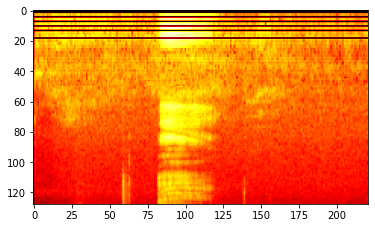

<Figure size 432x288 with 0 Axes>

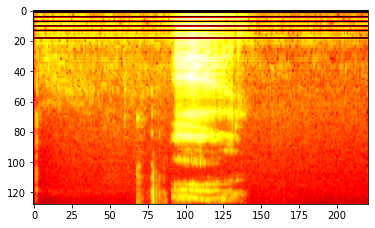

<Figure size 432x288 with 0 Axes>

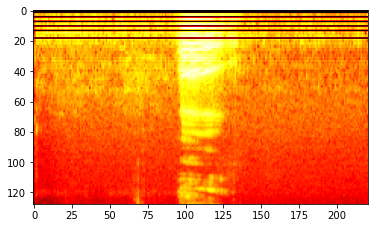

<Figure size 432x288 with 0 Axes>

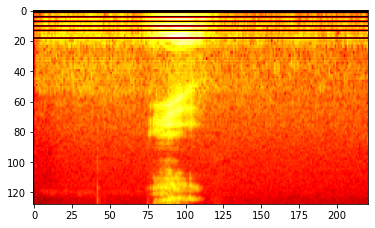

In [31]:
classes = list(np.unique(df.label))
wavforms = []
fixed_sample_rate = 22050

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    waveform, sample_rate = torchaudio.load('vowelAudio/'+c+'/'+wav_file, normalize=True)
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=fixed_sample_rate)
    audio_mono = torch.mean(resample_transform(waveform), dim=0, keepdim=True)
    wavforms.append(audio_mono)
    print(c)
    plt.figure()
#     print_stats(waveform, sample_rate=sample_rate)
#     plot_waveform(audio_mono, fixed_sample_rate)
    mel_spectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128)
    melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()
    
    melspectogram = mel_spectogram_transform(audio_mono)
#     plt.figure()
#     plt.imshow(melspectogram.squeeze().numpy(), cmap='hot')

    melspectogram_db=melspectogram_db_transform(melspectogram)
    plt.figure()
    plt.imshow(melspectogram_db.squeeze().numpy(), cmap='hot')
    
    print(melspectogram_db.shape)

/Users/anthony/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


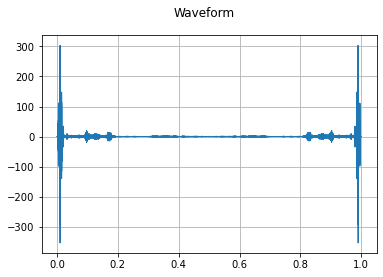

torch.Size([1, 44100])

In [33]:
fft = torch.fft.fft(wavforms[1], n=44100)
plot_waveform(fft, sample_rate)
fft.shape

In [77]:
one_hot = pd.get_dummies(df['label'])
classes = ['a', 'e', 'i', 'o', 'u']
one_hot

,a,e,i,o,u
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
61,0,1,0,0,0
62,0,1,0,0,0
63,0,1,0,0,0
64,0,1,0,0,0


In [104]:
fixed_sample_rate = 22050 #22050
class AudioDataset(Dataset):
    def __init__(self, files_dir, df, transform=None):
        self.transform = transform 
        self.df = df
        self.audio_files = self.df['fname']
        self.labels = np.array(pd.get_dummies(self.df['label']))
        self.files_dir = files_dir
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = classes[torch.argmax(torch.tensor(self.labels[index]))]
        audio_file_loc = os.path.join(self.files_dir+'/'+label,self.audio_files[index])
        waveform, sr = torchaudio.load(audio_file_loc, normalize=True)
        
        resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=fixed_sample_rate)
        audio_mono = torch.mean(resample_transform(waveform), dim=0, keepdim=True).to(device)
        
        mel_spectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128).to(device)
        melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()
        melspectogram = mel_spectogram_transform(audio_mono)
        melspectogram_db = melspectogram_db_transform(melspectogram)
        
        fixed_length = 3 * (fixed_sample_rate//200)
        if melspectogram_db.shape[2] < fixed_length:
            melspectogram_db = torch.nn.functional.pad(
              melspectogram_db, (0, fixed_length - melspectogram_db.shape[2]))
        else:
            melspectogram_db = melspectogram_db[:, :, :fixed_length]
        
        label = torch.tensor(self.labels[index]).to(device)
        
        if self.transform is not None:
            waveform = self.transform(audio_file)
            
        return melspectogram_db,label

In [105]:
dset = AudioDataset('vowelAudio', df)
dset

In [106]:
audio, label = dset.__getitem__(40)
audio.shape, label

(torch.Size([1, 128, 330]), tensor([0, 0, 0, 1, 0], dtype=torch.uint8))

In [107]:
train_loader = DataLoader(dset,batch_size=8,shuffle=True)

Epoch [1/5], Step [1,9], Loss: 1.8702, Accuracy: 12.50%
Epoch [1/5], Step [2,9], Loss: 1.8378, Accuracy: 37.50%
Epoch [1/5], Step [3,9], Loss: 1.8964, Accuracy: 25.00%
Epoch [1/5], Step [4,9], Loss: 1.7301, Accuracy: 50.00%
Epoch [1/5], Step [5,9], Loss: 0.6339, Accuracy: 100.00%
Epoch [1/5], Step [6,9], Loss: 0.4079, Accuracy: 100.00%
Epoch [1/5], Step [7,9], Loss: 0.5313, Accuracy: 87.50%
Epoch [1/5], Step [8,9], Loss: 0.4097, Accuracy: 100.00%
Epoch [1/5], Step [9,9], Loss: 0.5065, Accuracy: 100.00%
Epoch [2/5], Step [1,9], Loss: 0.0602, Accuracy: 100.00%
Epoch [2/5], Step [2,9], Loss: 0.3048, Accuracy: 87.50%
Epoch [2/5], Step [3,9], Loss: 0.1520, Accuracy: 100.00%
Epoch [2/5], Step [4,9], Loss: 0.0659, Accuracy: 100.00%
Epoch [2/5], Step [5,9], Loss: 0.1813, Accuracy: 100.00%
Epoch [2/5], Step [6,9], Loss: 1.3014, Accuracy: 75.00%
Epoch [2/5], Step [7,9], Loss: 0.1782, Accuracy: 100.00%
Epoch [2/5], Step [8,9], Loss: 0.5729, Accuracy: 87.50%
Epoch [2/5], Step [9,9], Loss: 3.2454, 

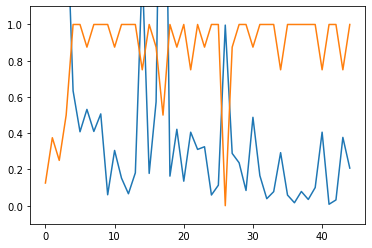

In [109]:
#training
model = models.resnet18(pretrained=True)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(device)

loss_list, acc_list = [],[]
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 5
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        label = torch.max(labels,1)[1]
        loss = loss_func(outputs,label)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        
        _, predicted = torch.max(outputs.data,1)
        correct = (predicted == label).sum().item()
        acc_list.append(correct/total)
        
        print('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                       (correct/total)*100))
    
plt.ylim(-0.1,1.1)
plt.plot(loss_list)
plt.plot(acc_list)

In [115]:
model.eval()
waveform, sr = torchaudio.load('test/u/uData_20_24_28.wav', normalize=True)
        
resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=fixed_sample_rate)
audio_mono = torch.mean(resample_transform(waveform), dim=0, keepdim=True).to(device)

mel_spectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128).to(device)
melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()
melspectogram = mel_spectogram_transform(audio_mono)
melspectogram_db = melspectogram_db_transform(melspectogram)

fixed_length = 3 * (fixed_sample_rate//200)
if melspectogram_db.shape[2] < fixed_length:
    melspectogram_db = torch.nn.functional.pad(
      melspectogram_db, (0, fixed_length - melspectogram_db.shape[2]))
else:
    melspectogram_db = melspectogram_db[:, :, :fixed_length]

melspectogram_db = melspectogram_db.unsqueeze(0)
    
with torch.no_grad():
    output = model(melspectogram_db)
print(torch.argmax(output))
print(classes[torch.argmax(output)])
output

tensor(4)
u


tensor([[-0.2083,  2.4146, -0.7150, -5.2909, 12.2974, -4.4424, -5.9096, -5.9943,
         -4.7213, -3.1552]])